In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
class Model(nn.Module):
     
    def __init__(self):
        super().__init__()
        self.stepLength = 2
        
        self.layer1 = nn.Linear(1, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, 1)
  
    def forward_DNN(self, x):    
        y = torch.relu(self.layer1(x))
        y = torch.relu(self.layer2(y))
        y = self.layer3(y)
     
        return y*torch.exp(-0.1*x**2) #regularizing function to make sampling from untrained model possible
    
    def sample(self, N, n):
        total = 0
        x = torch.Tensor(4*np.random.random((N,1)) - 2) #initiate N walkers between -2 and 2
        psi_old = self.forward_DNN(x)
        
        for i in range(n):
            x_new = x + self.stepLength*torch.Tensor(2*np.random.random((N,1)) - 1)
            psi_new = self.forward_DNN(x_new)
            
            idx = (psi_new/psi_old)**2 > torch.Tensor(np.random.random((N,1))) #vectorized acceptance criterion
            
            
            x[idx] = x_new[idx] #move walkers
            psi_old[idx] = psi_new[idx]
            total += torch.sum(idx)
            
        return x, total    

In [3]:
torch.manual_seed(42)
np.random.seed(42)
model = Model()
optimizer = torch.optim.Adam(model.parameters())

### Training

In [4]:
epochs = 500
N = 1000
h = 0.01 #finite difference

for epoch in tqdm(range(epochs)):
    PE_acc = 0
    P_acc = 0
    E_acc = 0
    

    x = model.sample(10000, 20)[0].detach() #Sample N positions, using 20 steps to remove corrolation 
    psi_plus = model.forward_DNN(x+h)
    psi = model.forward_DNN(x)
    psi_minus = model.forward_DNN(x-h)
    
    lap = 1/psi*(psi_plus - 2*psi + psi_minus)/h**2

    kinetic = -0.5*lap
    potential = 0.5*x**2



    E_L = (kinetic + potential).detach()

    PE = torch.mean(torch.log(psi)*E_L)
    P  = torch.mean(torch.log(psi))
    E  = torch.mean(E_L)  
    
    loss = 2*(PE - P*E)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    if epoch%100 == 0: 
        print(f"epoch: {epoch}, Energy: {E.item()}")

  1%|          | 5/500 [00:00<00:26, 18.61it/s]

epoch: 0, Energy: 4.237611770629883


 21%|██        | 104/500 [00:04<00:17, 22.43it/s]

epoch: 100, Energy: 0.5120577216148376


 41%|████      | 203/500 [00:08<00:13, 22.29it/s]

epoch: 200, Energy: 0.5041437745094299


 61%|██████    | 305/500 [00:13<00:08, 21.85it/s]

epoch: 300, Energy: 0.5122098922729492


 81%|████████  | 404/500 [00:17<00:04, 22.89it/s]

epoch: 400, Energy: 0.5108368992805481


100%|██████████| 500/500 [00:21<00:00, 22.99it/s]


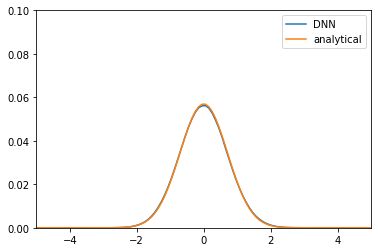

In [5]:
x_lin = torch.linspace(-5, 5, 100).reshape(100,-1)

psi1 = model.forward_DNN(x_lin)[:,0].detach().numpy()
psi2 = torch.exp(-0.5*x_lin[:,0]**2)

plt.plot(x_lin[:,0], psi1**2/np.sum(psi1**2))
plt.plot(x_lin[:,0], psi2**2/torch.sum(psi2**2))
plt.legend(["DNN", "analytical"])

plt.xlim((-5,5))
plt.ylim((0, 0.1))

plt.show()


### Check metropolis sampling

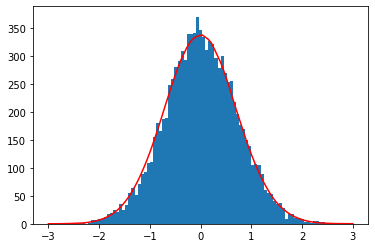

In [6]:
N = 10000

x_lin = torch.linspace(-3, 3, 100).reshape(100,-1)
dx = x_lin[1] - x_lin[0]

psi = model.forward_DNN(x_lin)[:,0].detach().numpy()

x = model.sample(N, 20)[0].detach().numpy()

bins = np.linspace(-3, 3, 100)
plt.hist(x, bins=bins)
plt.plot(x_lin[:,0], N*psi**2/np.sum(psi**2), "r")
plt.show()

## Estimating energy

In [7]:
N = 10000
x = model.sample(10000, 20)[0].detach() #Sample N positions, using 20 steps to remove corrolation 
psi_plus = model.forward_DNN(x+h)
psi = model.forward_DNN(x)
psi_minus = model.forward_DNN(x-h)

lap = 1/psi*(psi_plus - 2*psi + psi_minus)/h**2

kinetic = -0.5*lap
potential = 0.5*x**2

E = torch.mean(kinetic + potential)
    

print(E.item())

0.5046917200088501
